# John's House Price

### Importing Packages

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import time
import numpy as np
import pandas as pd # to read in csv
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


import nltk

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

### Load and Inspect Data

In [2]:
#Read in data

# house price data
train_df_raw = pd.read_csv("data_raw\\train.csv") 
test_df_raw = pd.read_csv("data_raw\\test.csv")

print("Train Shape:", train_df_raw.shape)
print("Test Shape:", test_df_raw.shape)
print(train_df_raw.dtypes)
train_df_raw.head(2)

Train Shape: (1460, 81)
Test Shape: (1459, 80)
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


### Check Missingness

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscFeature      object
dtype: object

Feature MasVnrType has NaN at following indices: [ 235  530  651  937  974  978 1244 1279]

Number of features with 

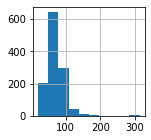

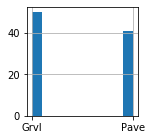

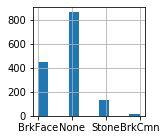

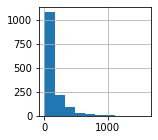

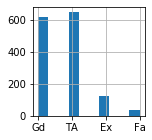

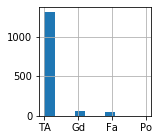

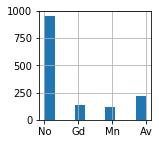

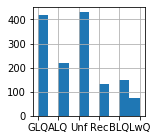

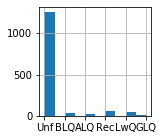

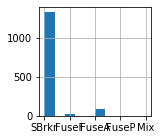

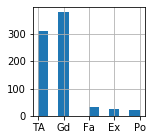

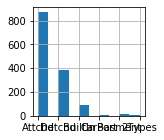

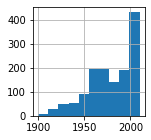

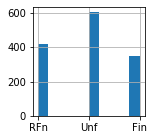

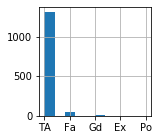

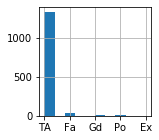

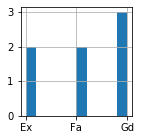

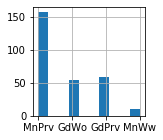

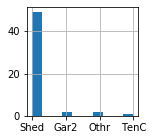

In [3]:
# TRAINING DATA MISSINGNESS

# Raw data has several columns with missing data
print( train_df_raw.isnull().sum(axis=0)[train_df_raw.isnull().sum(axis=0) != 0])
print("")

#Types of missing data
df_missing_data = train_df_raw.isnull().sum(axis=0)[train_df_raw.isnull().sum(axis=0) != 0].index
print(train_df_raw[df_missing_data].dtypes)
print("")

# Code to see which sample Id has missing data per feature
feature='MasVnrType'
print("Feature %s has NaN at following indices:" %feature, train_df_raw["Id"][train_df_raw[feature].isnull()].unique())
print("")

#histograms of features with missing data
print("Number of features with missing data:", len(df_missing_data))
for i in range(len(df_missing_data)):
    train_df_raw[df_missing_data[i]].hist(figsize=(2,2))
    plt.show()

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

MSZoning         object
LotFrontage     float64
Alley            object
Utilities        object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtF

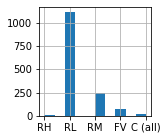

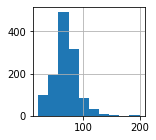

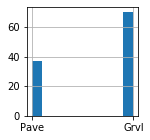

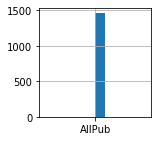

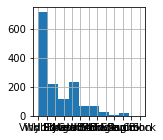

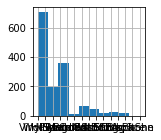

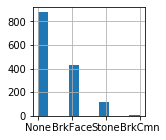

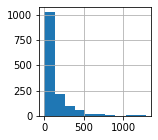

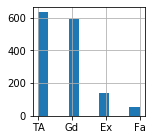

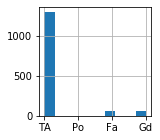

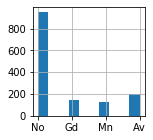

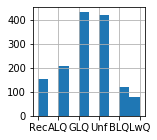

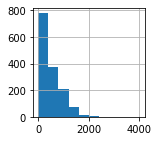

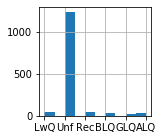

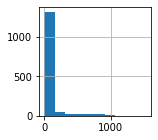

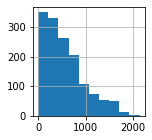

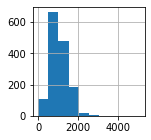

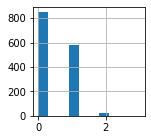

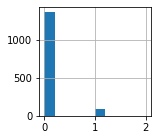

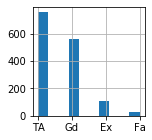

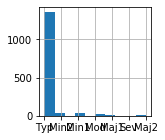

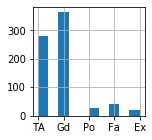

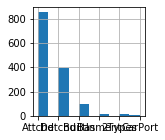

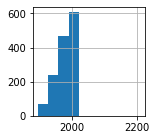

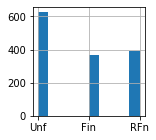

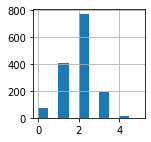

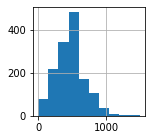

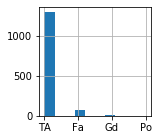

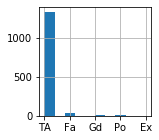

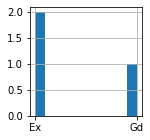

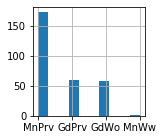

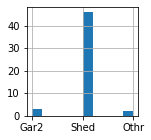

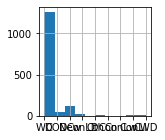

In [4]:
# TEST DATA MISSINGNESS

# Raw data has several columns with missing data
print( test_df_raw.isnull().sum(axis=0)[test_df_raw.isnull().sum(axis=0) != 0])
print("")

#Types of missing data
df_missing_data2 = test_df_raw.isnull().sum(axis=0)[test_df_raw.isnull().sum(axis=0) != 0].index
print(test_df_raw[df_missing_data2].dtypes)
print("")

# Code to see which sample Id has missing data per feature
feature='MasVnrType'
print("Feature %s has NaN at following indices:" %feature, test_df_raw["Id"][test_df_raw[feature].isnull()].unique())
print("")

#histograms of features with missing data
print("Number of features with missing data:", len(df_missing_data2))
for i in range(len(df_missing_data2)):
    test_df_raw[df_missing_data2[i]].hist(figsize=(2,2))
    plt.show()

In [5]:
#Drop columns with NA rows
train_df=train_df_raw.dropna(axis=1)
test_df=test_df_raw.dropna(axis=1)

# check if dropping NA worked
print("Train Data w/ NaN? ->", train_df.isnull().sum(axis=0)[train_df.isnull().sum(axis=0) != 0])
print("Test Data w/ NaN? ->", test_df.isnull().sum(axis=0)[test_df.isnull().sum(axis=0) != 0])
#Series is empty means all the NaN data is removed.

print(train_df.shape)
print(test_df.shape)

Train Data w/ NaN? -> Series([], dtype: int64)
Test Data w/ NaN? -> Series([], dtype: int64)
(1460, 62)
(1459, 47)


### Generate Summary Statistics

In [6]:
train_df.describe(include = 'all')

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1460.000000,1460,1460,1460,1460,1460,1460,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,2,4,4,2,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,1454,925,1311,1459,1052,1382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,...,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,...,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,7553.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,9478.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,11601.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [7]:
test_df.describe(include = 'all')

,Id,MSSubClass,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleCondition
count,1459.000000,1459.000000,1459.000000,1459,1459,1459,1459,1459,1459,1459,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459
unique,NaN,NaN,NaN,2,4,4,5,3,25,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
top,NaN,NaN,NaN,Pave,Reg,Lvl,Inside,Gtl,NAmes,Norm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
freq,NaN,NaN,NaN,1453,934,1311,1081,1396,218,1251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1204
mean,2190.000000,57.378341,9819.161069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705,NaN
std,421.321334,42.746880,4955.517327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740,NaN
min,1461.000000,20.000000,1470.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,NaN
25%,1825.500000,20.000000,7391.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,NaN
50%,2190.000000,50.000000,9399.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,NaN
75%,2554.500000,70.000000,11517.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,NaN


In [8]:
#Duplicates?

# There are no perfectly duplicated rows
print("Duplicates in Train Data:",sum(train_df.duplicated()))
print("Duplicates in Test Data:",sum(test_df.duplicated()))

Duplicates in Train Data: 0
Duplicates in Test Data: 0


### Train/Dev Data with a few columns

In [9]:
train_df
sf_columns=['GrLivArea', 'TotalBsmtSF','SalePrice']
train_df1=train_df[sf_columns]
train_df1.head()
# LotArea: Lot size in square feet
# BsmtFinSF1: Type 1 finished square feet
# BsmtFinSF2: Type 2 finished square feet
# BsmtUnfSF: Unfinished square feet of basement area
# TotalBsmtSF: Total square feet of basement area    
# 1stFlrSF: First Floor square feet 
# 2ndFlrSF: Second floor square feet
# LowQualFinSF: Low quality finished square feet (all floors)
# GrLivArea: Above grade (ground) living area square feet    
# GarageArea: Size of garage in square feet
# WoodDeckSF: Wood deck area in square feet
# OpenPorchSF: Open porch area in square feet
# EnclosedPorch: Enclosed porch area in square feet
# 3SsnPorch: Three season porch area in square feet
# ScreenPorch: Screen porch area in square feet
# PoolArea: Pool area in square feet

,GrLivArea,TotalBsmtSF,SalePrice
0,1710,856,208500
1,1262,1262,181500
2,1786,920,223500
3,1717,756,140000
4,2198,1145,250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B0432E7448>,
      dtype=object)

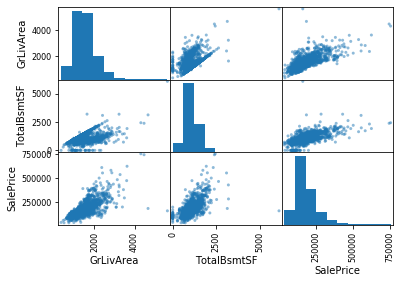

In [10]:
pd.plotting.scatter_matrix(train_df1)

In [34]:
X = train_df1.iloc[:,:-1]
y = train_df1.iloc[:,-1]
train_data_bl, dev_data_bl, train_labels_bl, dev_labels_bl = train_test_split(X,y, test_size=0.2)  #for baseline

In [35]:
#Linear regression model
lr = LinearRegression(fit_intercept=True)
lr.fit(train_data_bl, train_labels_bl)                 #fit model
print ("Estimated function: y = %.2f + (x%d) w_i*x_i" %(lr.intercept_, len(lr.coef_)))
accuracies_prediction = lr.predict(dev_data_bl)    #predict
print("R^2:",lr.score(train_data_bl,train_labels_bl))    #Finding R^2
print("Accuracy:",lr.score(dev_data_bl,dev_labels_bl))    #Finding accuracy of dev data

Estimated function: y = -9358.94 + (x2) w_i*x_i
R^2: 0.5887666586414173
Accuracy: 0.6929913885569763


..........................................................................................
k-Nearest Neighbors:  
Best f1_score is 0.007 when K is 41


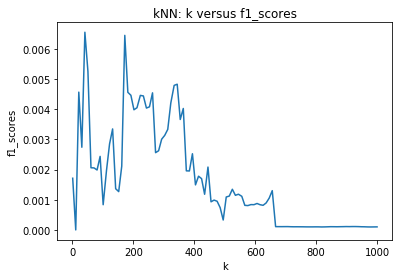

In [13]:
#K-Nearest Neighbors

print("."*90)
print("k-Nearest Neighbors:  ")
K= [int(x) for x in np.linspace(1,1000,100)]  
f1_scores = {}
for k in K:
    # k-Nearest Neighbors Model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_data_bl, train_labels_bl)  
    dev_predicted_labels = knn.predict(dev_data_bl)
    # finding, printing, and storing f1_score    
    f1_score = metrics.f1_score(dev_labels_bl, dev_predicted_labels, average='weighted')
    #print("For K: %d, f1_score: %.3f" %(k,f1_score))
    f1_scores[k] = f1_score
best = max(f1_scores, key=f1_scores.get)
print("Best f1_score is %.3f when K is %s" %(f1_scores[best],best))
#Plotting
fig1=plt.figure()
fig1=plt.title('kNN: k versus f1_scores')
fig1=plt.xlabel('k')
fig1=plt.ylabel('f1_scores')
fig1=plt.plot(list(f1_scores.keys()), list(f1_scores.values()))

..........................................................................................
Naive Bayes:  
Best f1_score is 0.000 when alpha is 1e-10


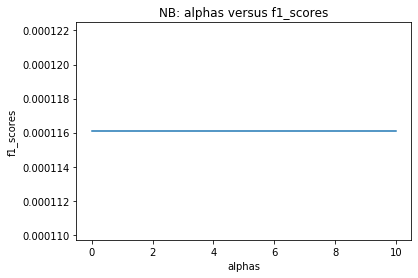

In [14]:
#Naive Bayes

print("."*90)
print("Naive Bayes:  ")
alphas = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]  
#varying by magnitudes of alpha to capture a wide range of values
f1_scores = {}
for alpha in alphas:
    # Naive Bayes Model
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(train_data_bl, train_labels_bl)
    dev_predicted_labels = mnb.predict(dev_data_bl)
    # finding, printing, and storing f1_score    
    f1_score = metrics.f1_score(dev_labels_bl, dev_predicted_labels, average='weighted')
    #print("For Alpha: %s, f1_score: %.03f" %(alpha,f1_score))
    f1_scores[alpha] = f1_score
best = max(f1_scores, key=f1_scores.get)
print("Best f1_score is %0.03f when alpha is %s" %(f1_scores[best],best))
#Plotting
fig2=plt.figure()
fig2=plt.title('NB: alphas versus f1_scores')
fig2=plt.xlabel('alphas')
fig2=plt.ylabel('f1_scores')
#plt.xscale('log')
fig2=plt.plot(list(f1_scores.keys()), list(f1_scores.values()))

### Train/Dev Data with all columns

In [68]:
train_df.shape
train_df.columns

#81 original features/columns becomes 62 features/columns after removing featurets/columns with NaN data

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageCars', 'GarageArea', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

In [93]:
#Converted all categorical data to dummy variables
#columns expanded from 62 to 216
np.random.seed(0)

dummies_df = pd.get_dummies(train_df)
X=dummies_df.drop(['SalePrice'],axis=1)
y=dummies_df['SalePrice']

# #scale values between 0 and 1
# features=X.columns.values
# scaler=MinMaxScaler(feature_range=(0,1))
# scaler.fit(X)
# X=pd.DataFrame(scaler.transform(X))
# X.columns=features


train_data_ac, dev_data_ac, train_labels_ac, dev_labels_ac = train_test_split(X,y, test_size=0.2)
print('training data shape:', train_data_ac.shape)
print('training label shape:', train_labels_ac.shape)
print('dev dat shape:',      dev_data_ac.shape)
print('dev label shape:',      dev_labels_ac.shape)
train_data_ac.head()

training data shape: (1168, 216)
training label shape: (1168,)
dev dat shape: (292, 216)
dev label shape: (292,)


,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
618,619,20,11694,9,5,2007,2007,48,0,1774,...,0,1,0,0,0,0,0,0,0,1
870,871,20,6600,5,5,1962,1962,0,0,894,...,0,0,0,1,0,0,0,0,1,0
92,93,30,13360,5,7,1921,2006,713,0,163,...,0,0,0,1,0,0,0,0,1,0
817,818,20,13265,8,5,2002,2002,1218,0,350,...,0,0,0,1,0,0,0,0,1,0
302,303,20,13704,7,5,2001,2002,0,0,1541,...,0,0,0,1,0,0,0,0,1,0


In [94]:
# NOT SURE IF DONE CORRECTLY

#Linear regression model
def linr():
    lr = LinearRegression(fit_intercept=True)
    lr.fit(train_data_ac, train_labels_ac)                 #fit model
    print ("Estimated function: y = %.2f + (x%d) w_i*x_i" %(lr.intercept_, len(lr.coef_)))
    accuracies_prediction = lr.predict(dev_data_ac)    #predict
    print("R^2:",lr.score(train_data_ac,train_labels_ac))    #Finding R^2
    print("Accuracy:",lr.score(dev_data_ac,dev_labels_ac))    #Finding accuracy of dev data
    # lr.coef_[abs(lr.coef_) > 0.1]
    #np.where([abs(lr.coef_) > 0.1])
    #print(lr.coef_)
    print("prediction prices:", accuracies_prediction)
linr()

Estimated function: y = -1031417.11 + (x216) w_i*x_i
R^2: 0.9306889059525217
Accuracy: 0.573540758837457
prediction prices: [275214.38942719 145240.33301373 117205.92149905 216336.46894249
  98387.25223346  90386.48993408 247551.3468477  131491.70865098
 545206.525338   147809.96313621 204263.2307743   47166.92112814
 231052.15116444 115065.15368798 115323.30949185 149965.16503602
 260421.19275935 121570.11091196 139375.13878449 188098.93610119
 129675.06580688 164541.79498095  97555.1140713  151699.30242601
 180352.93038178 155421.96342973 160106.23709728  57388.76224261
 330185.62590481 110777.58305944 145599.04470293 205097.82662452
 153564.95973383 295821.60031197 325027.28621149 194563.85389882
 318121.69064625 118547.66998819 234327.1859413  338443.39508773
 209099.55048769 110905.99605958 198537.61217853 298317.55251253
 370781.98708455 126886.86996326  30733.22308929 127170.26021461
 182119.73223782  72833.18939428 381896.62931061 148999.8378341
 168562.11861074  70544.34155495

In [75]:
#logistic regression model

def logr():
    c=0.5
    lr = LogisticRegression(C=c, solver="liblinear", multi_class="auto")  #default regularization = l2
    lr.fit(train_data_ac,train_labels_ac)
    dev_predicted_labels=lr.predict(dev_data_ac)
    # finding, printing, and storing f1_score    
    f1_score=metrics.f1_score(dev_labels_ac,dev_predicted_labels,average='weighted')
    print("For C = %s, f1_score = %.30f" %(c,f1_score))
logr()

For C = 0.5, f1_score = 0.003424657534246575152359071126


C:\Users\johnl\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


..........................................................................................
k-Nearest Neighbors:  
Best f1_score is 0.008371385083713852107156760951 when K is 11


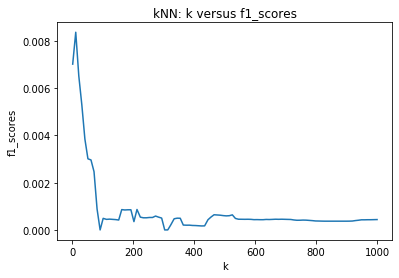

In [76]:
#K-Nearest Neighbors

def kNN():
    print("."*90)
    print("k-Nearest Neighbors:  ")
    K= [int(x) for x in np.linspace(1,1000,100)]    #runs kNN for x100 k's between 1 to 1000
    f1_scores = {}   #stores f1_scores for each k
    for k in K:
        # k-Nearest Neighbors Model
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train_data_ac, train_labels_ac)  
        dev_predicted_labels = knn.predict(dev_data_ac)
        # finding, printing, and storing f1_score    
        f1_score = metrics.f1_score(dev_labels_ac, dev_predicted_labels, average='weighted')
        #print("For K: %d, f1_score: %.3f" %(k,f1_score))
        f1_scores[k] = f1_score
    best = max(f1_scores, key=f1_scores.get)
    print("Best f1_score is %.30f when K is %s" %(f1_scores[best],best))
    #Plotting
    fig1=plt.figure()
    fig1=plt.title('kNN: k versus f1_scores')
    fig1=plt.xlabel('k')
    fig1=plt.ylabel('f1_scores')
    fig1=plt.plot(list(f1_scores.keys()), list(f1_scores.values()))
kNN()

..........................................................................................
Naive Bayes:  
Best f1_score is 0.008088714938030006421088025093 when alpha is 10.0


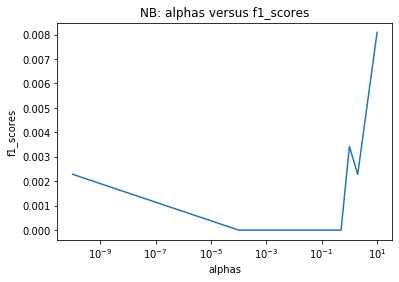

In [77]:
#Naive Bayes

def NB():
    print("."*90)
    print("Naive Bayes:  ")
    alphas = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]  
    #varying by magnitudes of alpha to capture a wide range of values
    f1_scores = {}      #stores f1_scores for each alpha
    for alpha in alphas:
        # Naive Bayes Model
        mnb = MultinomialNB(alpha=alpha)
        mnb.fit(train_data_ac, train_labels_ac)
        dev_predicted_labels = mnb.predict(dev_data_ac)
        # finding, printing, and storing f1_score    
        f1_score = metrics.f1_score(dev_labels_ac, dev_predicted_labels, average='weighted')
        #print("For Alpha: %s, f1_score: %.03f" %(alpha,f1_score))
        f1_scores[alpha] = f1_score
    best = max(f1_scores, key=f1_scores.get)
    print("Best f1_score is %0.30f when alpha is %s" %(f1_scores[best],best))
    #Plotting
    fig2=plt.figure()
    fig2=plt.title('NB: alphas versus f1_scores')
    fig2=plt.xlabel('alphas')
    fig2=plt.ylabel('f1_scores')
    plt.xscale('log')
    fig2=plt.plot(list(f1_scores.keys()), list(f1_scores.values()))
NB()